### MIT Shocks

- The general principle is to consider an economy that is at its steady-state in period $t$.

- Then we expose the economy to some temporary shock, under the assumption that the economy will fully have reverted back to its steady-state in period $t + T$.

- Then it’s not that hard to calculate the transition of the economy between period $t$ and $t + T$. Just compute the perfect foresight transition back to steady state!

#### Algorithm

- General principle: Guess how the capital stock will evolve from period $t + 1$ to period $t + T$ , assuming that
it’s back to it’s steady state value in $t + T + 1$. Call this guess$\{k_{t+s}^0 \}^T_{s=1}$.


- Given this guess, we can calculate wages and interest rates as $w^0_{t+s} = exp(z_{t+s})F_n(k^0_t,n)$ and
$\tilde{r}^0_{t+s} = exp(z_{t+s})F_k(k^0_t,n)$


- 􏰀 Using time iteration again, we can find $\tilde{g}(a, s)$ as
$$u^\prime((1+r^0_{t+s} )a+w^0_{t+s}−\tilde{g}(a,s)) = β(1 + r^0_{t+s+1}) \sum_{s^\prime} 􏰇 u^\prime((1 + r^0_{t+s+1} )\tilde{g}(a, s) + w^0_{t+s+1} − g^0_{t+s+1} (\tilde{g}(a, s), s′))p(s′, s)$$


- Then $g^0_{t+s}(a,s) =  max\{\tilde{g}(a,s), \phi  \}$, with $g_{t+T+1}(a,s)= g(a,s)$


- Then for each $g^0_t, g^0_{t+1} , ..., g^0_{t+s}$ we can find a transition matrix $M^0_{t+s}$


- Given that we know $ψ_t (a, s) = ψ(a, s)$, we can update matrix as $ψ^0_{t+s+1} = ψ^0_{t+s} × M^0_{t+s} $, and calculate the implied aggregate asset holdings $A^0_{t+s}$ 


- Finally Then we update our guess for the sequence of capital as 
$\{k^1_{t+s} \}^T_{s=1} = η\{k^0_{t+s} \}^T_{s=1} + (1 − η)\{A^0_{t+s} \}^T_{s=1}$ with $η ∈ (0, 1]$


- And repeat until $||\{k^{n+1}_{t+s}\}^T_{s=1} − \{k^n_{t+s} \}^T_{s=1}||<\epsilon$

### Example: Hugget Economy

In [636]:
import numpy as np
from scipy.interpolate import interp1d
%config InlineBackend.figure_format = 'retina'

gamma = 2.0
w= 5        # wages
β=1.03**(-1/12)       # discount factor
#r=0.00246       # interest rate
phi = -1.0
a_min= -3.0
Π = np.asarray([[0.4, 0.6], [0.6, 0.4]])  # Markov chain
z_vals=[0.5, 1]             
a_max=18
a_size=300
N = 300
mu = 0.5
a_vals = np.linspace(a_min,a_max,N)

In [474]:
def time_g(r0,w0, r1, w1):
    #bgrid = np.linspace(a_min,np.log(18-phi+1),N)
    #a_vals = np.exp(bgrid)+phi-1;
    ag1 = a_vals
    ab1 = a_vals
    ag = a_vals
    ab = a_vals
    metric = 1
    
    while metric > 1e-6:

        gg = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
        gb = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

        Eg = β*(1+r0)*( Π[0,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+Π[0,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )
        Eb = β*(1+r0)*( Π[1,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+Π[1,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )

        ag1 = (Eg**(-1/gamma)-w0+a_vals)/(1+r0)
        ab1 = (Eb**(-1/gamma)-mu*w0+a_vals)/(1+r0)
        
        metric = np.array(([abs(ag1-ag),abs(ab1-ab)])).max()

        ag = ag1
        ab = ab1

    return gg, gb

In [475]:
gg, gb = time_g(0.105, 5.0, 0.105, 5.0)

In [487]:
def agr_capital(gg, gb):
    
    a1g_star, a1b_star = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)
    F = interp1d(a_vals,a_vals, kind = 'next', fill_value = 18.0, bounds_error=False);
    a1gd_star = F(np.maximum(gg(a_vals),phi));
    a1bd_star = F(np.maximum(gb(a_vals),phi));

    Tg = np.zeros([N,N])
    Tb = np.zeros([N,N])

    for i in range(N):

        ixg = np.where(a_vals==a1gd_star[i])[0][0]
        Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
        if Tg[i,ixg] > 1:
            Tg[i,ixg] = 1.0
        Tg[i,ixg-1] = 1-Tg[i,ixg]

        ixb = np.where(a_vals==a1bd_star[i])[0][0]
        if ixb == 0:
            Tb[i,ixb] = 1
        else:
            Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
            Tb[i,ixb-1] = 1-Tb[i,ixb]


    P = Π

    M_t = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)


    from scipy.sparse import csr_matrix
    M = csr_matrix(M_t)

    M2 = csr_matrix.transpose(M)
    import scipy.sparse.linalg as sla


    D, V = sla.eigs(M2, k=1, sigma = 1.0)
    V = np.real(V)/sum(np.real(V))
    dist = V[0:N]+V[N:]
    mean_a = np.dot(a_vals.T,dist)
    
    return mean_a, M_t, dist, V

In [488]:
A, M, dist, V = agr_capital(gg, gb)

In [489]:
A

array([-3.8982706e-14])

In [490]:
def total_A(r):
    gg, gb = time_g(r, 5.0, r, 5.0)
    A, M, dist, V = agr_capital(gg, gb)
    return A

In [492]:
total_A(sol)

array([-3.93435284e-14])

In [292]:
import scipy.optimize as opt
sol = opt.root_scalar(total_A, bracket = [-0.11, -0.10]).root

In [293]:
sol

-0.10418860985914367

1- Create guess for interest rates.

In [649]:
s = 20 # Periods until back to steady state
r0s =  np.ones(s+1)*(sol)
ws = np.ones(s+1)*5
ws[0] = 5.05 # Shock in wage

In [650]:
# Find policy functions for each period of the simulation
ggs = []
gbs = []

for i in range(0,20):
    gg, gb = time_g(r0s[i], ws[i], r0s[i+1], ws[i+1])
    #gg, gb = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)
    ggs.append(gg)
    gbs.append(gb)

# Given policies, find transition matrices
Ms = []
for i in range(0,20):
    _, M, _, _ = agr_capital(ggs[i], gbs[i])
    Ms.append(M)
    
# Update distribution along simulation
phis = [V]
for i in range(0,20):
    dist1 = np.dot(phis[i].T, Ms[i])
    phis.append(dist1.T)
phis.remove(V)   

# Calculate implied Asset Holdings
As = []
for i in range(0,20):
    dist = phis[i][0:N]+phis[i][N:]
    As.append(np.dot(a_vals.T,dist))
    
# Calculate implied interest rates - How to get prices?



In [651]:
As

[array([0.06017229]),
 array([0.0360912]),
 array([0.02082366]),
 array([0.01224856]),
 array([0.00708238]),
 array([0.00414855]),
 array([0.00241852]),
 array([0.0014125]),
 array([0.00082358]),
 array([0.00048065]),
 array([0.00028046]),
 array([0.00016366]),
 array([9.5499726e-05]),
 array([5.57278462e-05]),
 array([3.25196195e-05]),
 array([1.89765594e-05]),
 array([1.10736404e-05]),
 array([6.46194859e-06]),
 array([3.77082977e-06]),
 array([2.20044363e-06])]

In [662]:
def agr_capital2(gg, gb):
    
    a1g_star, a1b_star = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)
    F = interp1d(a_vals,a_vals, kind = 'next', fill_value = 18.0, bounds_error=False);
    a1gd_star = F(np.maximum(gg(a_vals),phi));
    a1bd_star = F(np.maximum(gb(a_vals),phi));

    Tg = np.zeros([N,N])
    Tb = np.zeros([N,N])

    for i in range(N):

        ixg = np.where(a_vals==a1gd_star[i])[0][0]
        Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
        if Tg[i,ixg] > 1:
            Tg[i,ixg] = 1.0
        Tg[i,ixg-1] = 1-Tg[i,ixg]

        ixb = np.where(a_vals==a1bd_star[i])[0][0]
        if ixb == 0:
            Tb[i,ixb] = 1
        else:
            Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
            Tb[i,ixb-1] = 1-Tb[i,ixb]


    P = Π

    M_t = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)
    
    return M_t

In [663]:
def total_A(r0s, r1, j):
    ggs = []
    gbs = []
    r0s = np.hstack([r0s, sol])
    r0s[j] = r1
    #r0s[1:2] = r1
    for i in range(0,20):
        gg, gb = time_g(r0s[i], ws[i], r0s[i+1], ws[i+1])
        #gg, gb = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)
        ggs.append(gg)
        gbs.append(gb)

    # Given policies, find transition matrices
    Ms = []
    for i in range(0,20):
        M = agr_capital2(ggs[i], gbs[i])
        Ms.append(M)

    # Update distribution along simulation
    phis = [V]
    for i in range(0,20):
        dist1 = np.dot(phis[i].T, Ms[i])
        phis.append(dist1.T)
    phis.remove(V)   

    # Calculate implied Asset Holdings
    As = []
    for i in range(0,20):
        dist = phis[i][0:N]+phis[i][N:]
        As.append(np.dot(a_vals.T,dist))
    res = np.array(As).reshape(20)    
    return res[j]

In [690]:
total_A(r0s, r0s[0]-0.1, 0)

-0.2860204611370009

In [695]:
# Calculate implied interest rates - How to get prices?
r1s = []
eta = 0.2
j = 1
for i in range(0,20):
    r1 = opt.root_scalar(lambda r1: total_A(r0s, r1, i), bracket = [r0s[i]-0.001, r0s[i]+0.001] , method = 'brentq').root
    r0s[i] = r1
    print(j, r1)
    j+=1
r0s

1 -0.11860106105558217
2 -0.10409770737023728
3 -0.10411086285419949
4 -0.10418971044778745
5 -0.10418148407776523
6 -0.10418741041689726
7 -0.10418790041789515
8 -0.10418867411390707
9 -0.10418854298776745
10 -0.1041885952696304
11 -0.10418860165762045
12 -0.1041886083008467
13 -0.10418860889718652
14 -0.10418860958561026
15 -0.1041886097566642
16 -0.10418860983292995
17 -0.10418860984717633
18 -0.1041886098552869
19 -0.10418860985783644
20 -0.10418860985870615


array([-0.11860106, -0.10409771, -0.10411086, -0.10418971, -0.10418148,
       -0.10418741, -0.1041879 , -0.10418867, -0.10418854, -0.1041886 ,
       -0.1041886 , -0.10418861, -0.10418861, -0.10418861, -0.10418861,
       -0.10418861, -0.10418861, -0.10418861, -0.10418861, -0.10418861,
       -0.10418861])

In [696]:
# Find policy functions for each period of the simulation
ggs = []
gbs = []

for i in range(0,20):
    gg, gb = time_g(r0s[i], ws[i], r0s[i+1], ws[i+1])
    #gg, gb = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)
    ggs.append(gg)
    gbs.append(gb)

# Given policies, find transition matrices
Ms = []
for i in range(0,20):
    M = agr_capital2(ggs[i], gbs[i])
    Ms.append(M)
    
# Update distribution along simulation
phis = [V]
for i in range(0,20):
    dist1 = np.dot(phis[i].T, Ms[i])
    phis.append(dist1.T)
phis.remove(V)   

# Calculate implied Asset Holdings
As = []
dists = []
for i in range(0,20):
    dist = phis[i][0:N]+phis[i][N:]
    dists.append(dist)
    As.append(np.dot(a_vals.T,dist))

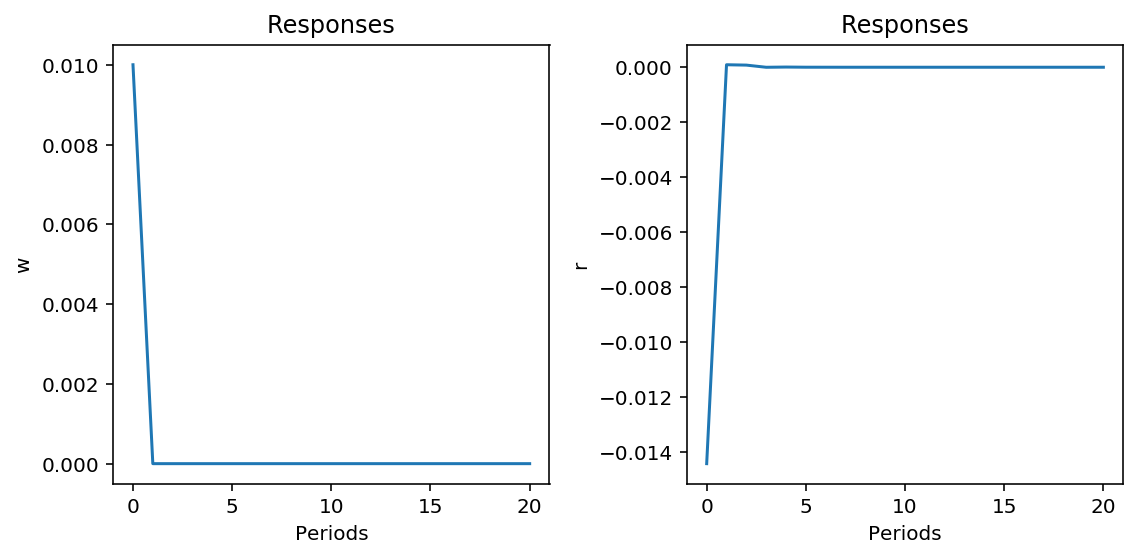

In [702]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(np.arange(0,s+1), (ws-w)/w)
ax[0].set_title('Responses')
ax[0].set_xlabel('Periods')
ax[0].set_ylabel('w')
ax[1].plot(np.arange(0,s+1), r0s-sol)
ax[1].set_title('Responses')
ax[1].set_xlabel('Periods')
ax[1].set_ylabel('r')
plt.tight_layout()
plt.show()

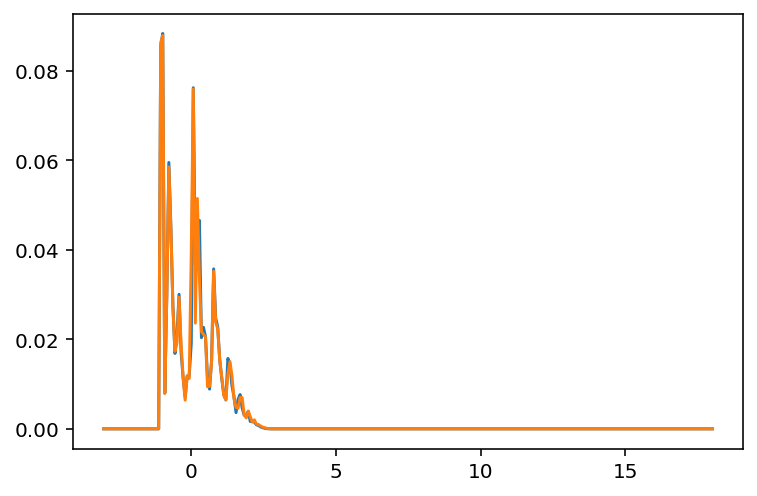

In [648]:
plt.figure(figsize=(6,4))
plt.plot(a_vals, dists[0])
#plt.plot(a_vals, dists[19])
plt.plot(a_vals, dist)
plt.show()

### MIT Shock in Aiyagari Model

In [353]:
## import numpy as np
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP
import scipy.optimize as opt
from scipy.interpolate import interp1d


gamma = 2
mu = 0.5
alpha = 1/3
phi = -1.0
beta = 1.03**(-1/12)
delta = 0.025
a_min = -3.0
a_max = 60.0
A = 1.0
L = 1.0
N = 100

P = np.array([[0.4,0.6], [0.6, 0.4]])


agrid = np.linspace(a_min,np.log(a_max-phi+1),N)
a_vals = np.exp(agrid)+phi-1


def rd(K, A = 1.0):
    return A * alpha * (L / K)**(1 - alpha) - delta

def r_to_w(r, A = 1.0):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - alpha) * (A * alpha / (r + delta))**(alpha / (1 - alpha))

def policy(r0, w0, r1, w1):
    ag1 = a_vals
    ab1 = a_vals
    ag = a_vals
    ab = a_vals
    metric = 1
    
    while metric > 1e-6:

        gg = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
        gb = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

        Eg = beta*(1+r1)*( P[0,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[0,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )
        Eb = beta*(1+r1)*( P[1,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[1,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )

        ag1 = (Eg**(-1/gamma)-w0+a_vals)/(1+r0)
        ab1 = (Eb**(-1/gamma)-mu*w0+a_vals)/(1+r0)
        
        metric = np.array(([abs(ag1-ag),abs(ab1-ab)])).max()

        ag = ag1
        ab = ab1

    return gg, gb


def makeTransition_M(gg, gb):
    a1g_star, a1b_star = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)
    F = interp1d(a_vals,a_vals, kind = 'next', fill_value = a_vals[-1], bounds_error=False);
    a1gd_star = F(np.maximum(gg(a_vals),phi));
    a1bd_star = F(np.maximum(gb(a_vals),phi));

    Tg = np.zeros([N,N])
    Tb = np.zeros([N,N])

    for i in range(N):
    
        ixg = np.where(a_vals==a1gd_star[i])[0][0]
        Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
        if Tg[i,ixg] > 1:
            Tg[i,ixg] = 1.0
        Tg[i,ixg-1] = 1-Tg[i,ixg]
    
        ixb = np.where(a_vals==a1bd_star[i])[0][0]
        if ixb == 0:
            Tb[i,ixb] = 1.0
        else:
            Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
            if Tb[i,ixb] > 1:
                Tb[i,ixb] = 1.0
            Tb[i,ixb-1] = 1-Tb[i,ixb]

        
    M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)

    return M

def GetStationaryDist(M):
    eval,evec = np.linalg.eig(M.T)
    i = np.argmin(np.abs(eval-1.0))
    D = np.array(evec[:,i]).flatten()
    assert np.max(np.abs(np.imag(D))) < 1e-6
    D = np.real(D)  # just recasts as float
    return D/D.sum()

def agr_capital(dist):
    a_dist = dist[0:N]+dist[N:]
    return np.dot(a_vals.T, a_dist)

def prices_to_capital(r):
    gg, gb = policy(r, r_to_w(r), r, r_to_w(r))
    M = makeTransition_M(gg,gb)
    dist = GetStationaryDist(M)
    K = agr_capital(dist)
    return K

def equilibrium_ss():
    res = lambda K: K - prices_to_capital(rd(K))
    Kss_certain =  ((1/beta-1+delta)/alpha)**(1./(alpha-1))
    sol  = opt.root_scalar(res, bracket = [0.8*Kss_certain,1.2*Kss_certain], method = 'brentq').root
    return sol


def policy_back(r0, w0, r1, w1, gg, gb):
    ag1 = a_vals
    ab1 = a_vals
    ag = a_vals
    ab = a_vals

    Eg = beta*(1+r1)*( P[0,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[0,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )
    Eb = beta*(1+r1)*( P[1,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[1,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )

    ag1 = (Eg**(-1/gamma)-w0+a_vals)/(1+r0)
    ab1 = (Eb**(-1/gamma)-mu*w0+a_vals)/(1+r0)

    gg1 = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
    gb1 = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

    return gg1, gb1

In [354]:
Kss = equilibrium_ss()

In [496]:
r = rd(Kss)
w = r_to_w(r)
gg, gb = policy(r, w, r, w)
M = makeTransition_M(gg, gb)
dist = GetStationaryDist(M)

In [497]:
M.T.shape

(200, 200)

In [498]:
dist.shape

(200,)

### TFP Shock

In [553]:
s = 50
As = np.ones(s+1)*1.0
As[0] = 1.01

In [554]:
# Guess K sequence
K0s = np.ones(s+1)*Kss

gg_ss, gb_ss = policy(rd(Kss), r_to_w(rd(Kss)), rd(Kss), r_to_w(rd(Kss)))

In [555]:
# Update Prices
rs = rd(K0s, As)
    
ws = r_to_w(rs, As)

rs

array([0.00285117, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542])

In [556]:
# Update Policies
ggs = [None] * s
ggs.insert(s, gg_ss)

gbs = [None] * s
gbs.insert(s, gb_ss)

for i in range(s,0,-1):
    r1 = rd(K0s[i], As[i])
    r0 = rd(K0s[i-1], As[i-1])
    w1 = r_to_w(r1, As[i])
    w0 = r_to_w(r0, As[i-1])
    gg1, gb1 = policy_back(r0, w0, r1, w1, ggs[i], gbs[i])
    ggs[i-1] = gg1
    gbs[i-1] = gb1

In [557]:
# Update Transition Matrices
Ms = [None]*s

for i in range(0,s,1):
    Ms[i]= makeTransition_M(ggs[i], gbs[i])

In [558]:
# Update Distributions
dists = [None]*s

for i in range(0,s,1):
    dists[i] = np.dot(dist, Ms[i])

In [559]:
# Update Aggregates
K1s = [None]*s
K1s.insert(s, Kss)

for i in range(0,s,1):
    K1s[i] = agr_capital(dists[i])

In [560]:
def update_agreggates(K0s):
    # Update Prices
    rs = rd(K0s, As)

    ws = r_to_w(rs, As)
    
    # Update Policies
    ggs = [None] * s
    ggs.insert(s, gg_ss)

    gbs = [None] * s
    gbs.insert(s, gb_ss)

    for i in range(s,0,-1):
        r1 = rd(K0s[i], As[i])
        r0 = rd(K0s[i-1], As[i-1])
        w1 = r_to_w(r1, As[i])
        w0 = r_to_w(r0, As[i-1])
        gg1, gb1 = policy_back(r0, w0, r1, w1, ggs[i], gbs[i])
        ggs[i-1] = gg1
        gbs[i-1] = gb1
        
    Ms = [None]*s

    for i in range(0,s,1):
        Ms[i]= makeTransition_M(ggs[i], gbs[i])
        
    # Update Distributions
    dists = [None]*s

    for i in range(0,s,1):
        dists[i] = np.dot(dist, Ms[i])
        
    K1s = [None]*s
    K1s.insert(s, Kss)

    for i in range(0,s,1):
        K1s[i] = agr_capital(dists[i])
    
    return np.array(K1s), ggs, gbs, dists

In [561]:
def equilibrium_trans(Kguess):
    for i in range(0,s):
        aggK, ggs, gbs, dists = update_agreggates(Kguess)
        dif = max(abs(Kguess-aggK))
        print(dif)
        if dif < 1e-6:
            return aggK, ggs, gbs, dists
        Kguess = 0.2*aggK + 0.8*Kguess

    print("Did not converge")

aggK, ggs, gbs, dists = equilibrium_trans(K0s)

0.026196390876691567
0.02093570668505862
0.016731467098601627
0.013371514824818576
0.010686299609808714
0.008540321137694207
0.006825290674754569
0.00545466618182644
0.004359285000582247
0.0034838736531028758
0.0027842585839792378
0.002225137064392868
0.001778295755521242
0.0014211870263025617
0.0011357911775888851
0.0009077071547309856
0.0007254258627398258
0.0005797494129922143
0.00046332699567841473
0.0003702839568973104
0.0002959253632255354
0.00023649909560674587
0.00018900651749476083
0.0001510511640248069
0.00012071781681299854
9.64758621648798e-05
7.710205677824433e-05
6.161880304489387e-05
4.924481962831351e-05
3.935571825763873e-05
3.145249728930821e-05
2.51363620407119e-05
2.008860182911576e-05
1.6054507852913957e-05
1.2830520702777903e-05
1.0253958720340961e-05
8.19480918323734e-06
6.549167913760812e-06
5.233996198228397e-06
4.182930801732709e-06
3.3429351731228962e-06
2.671623327898942e-06
2.1351210435227586e-06
1.7063564996533387e-06
1.363694337896959e-06
1.08984391289368

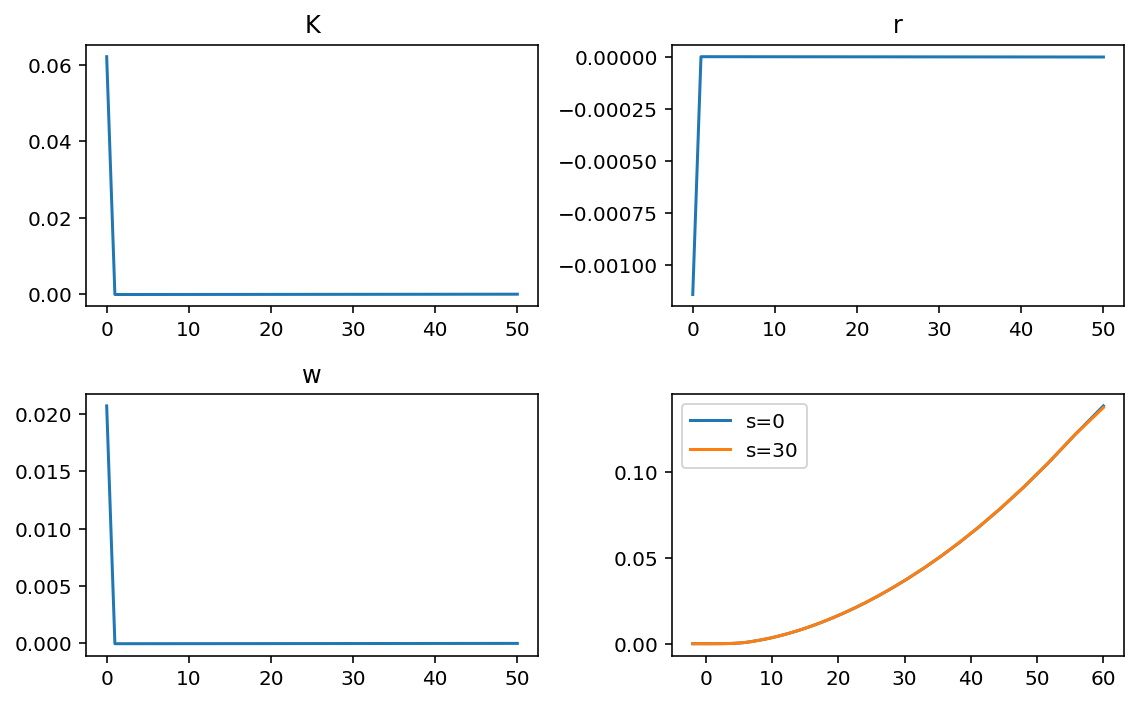

In [593]:
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(2,2, figsize = (8,5))
ax[0,0].plot(np.arange(0,s+1), (aggK-Kss)/Kss*100)
ax[0,0].set_title('K')
ax[0,1].plot(np.arange(0,s+1), (rd(aggK)-rd(Kss))*100)
ax[0,1].set_title('r')
ax[1,0].plot(np.arange(0,s+1), (r_to_w(rd(aggK))-r_to_w(rd(Kss)))/r_to_w(rd(Kss))*100)
ax[1,0].set_title('w')

ax[1,1].plot(a_vals, dists[0][0:N]+dists[0][N:], label = 's=0')
ax[1,1].plot(a_vals, dists[30][0:N]+dists[30][N:], label = 's=30')
ax[1,1].legend()
plt.tight_layout()
plt.show()